In [1]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
os.listdir('../input/plant-pathology-2020-fgvc7')

['test.csv', 'sample_submission.csv', 'train.csv', 'images']

In [3]:
train=pd.read_csv("../input/plant-pathology-2020-fgvc7/train.csv")
test=pd.read_csv("../input/plant-pathology-2020-fgvc7/test.csv")
train['image_id']=train['image_id']+'.jpg'
test['image_id']=test['image_id']+'.jpg'
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0.jpg,0,0,0,1
1,Train_1.jpg,0,1,0,0
2,Train_2.jpg,1,0,0,0
3,Train_3.jpg,0,0,1,0
4,Train_4.jpg,1,0,0,0


Text(0, 0.5, '')

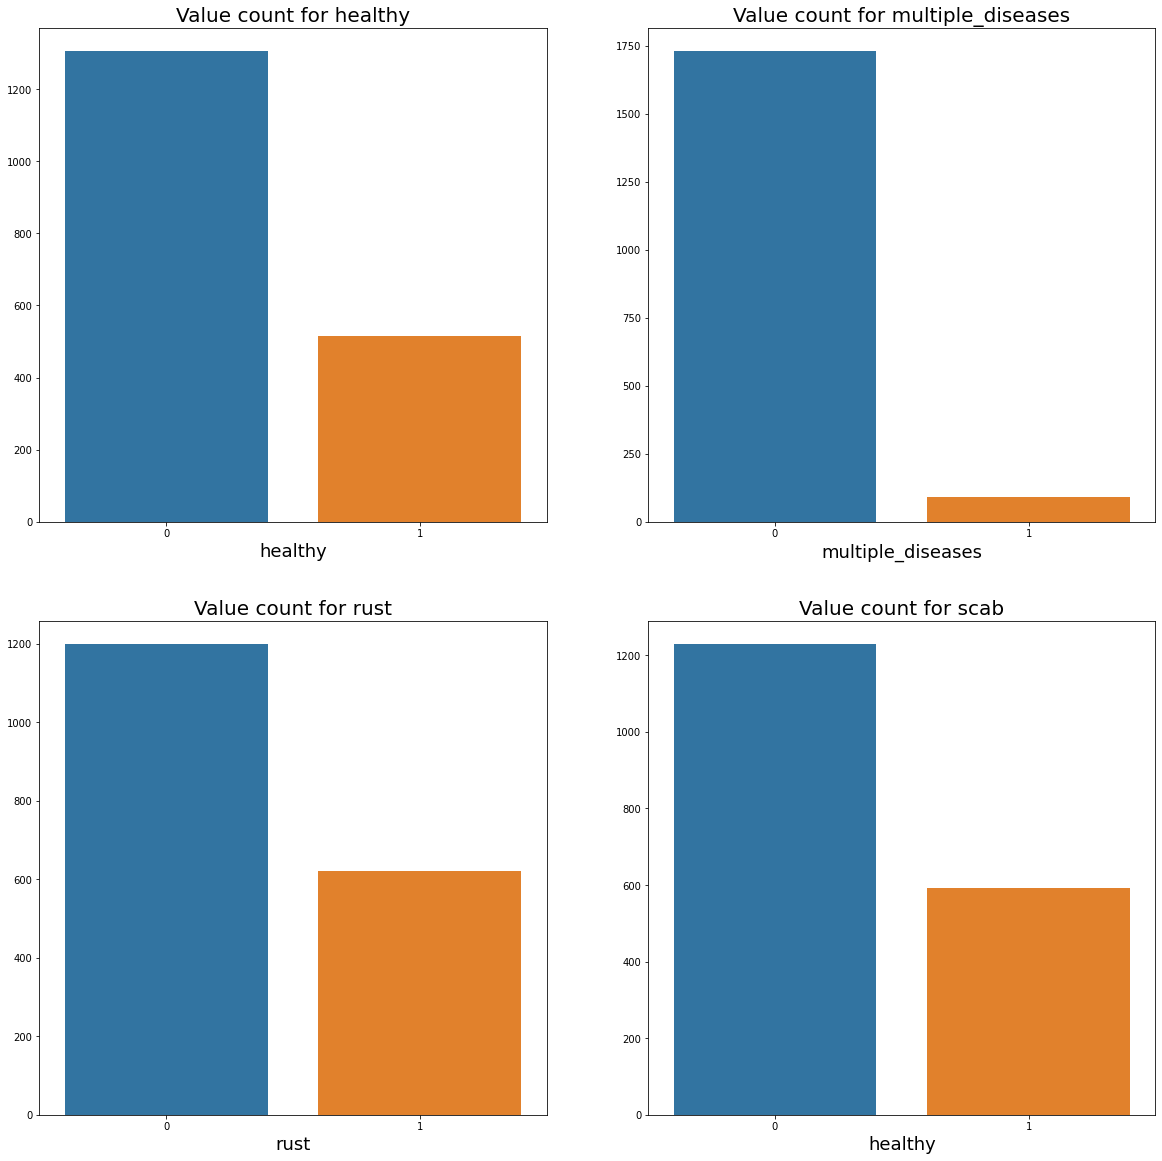

In [4]:
fig,ax=plt.subplots(2,2,figsize=(20,20))
sns.barplot(y=train.healthy.value_counts(),x=train.healthy.value_counts().index,ax=ax[0,0])
ax[0,0].set_title("Value count for healthy",size=20)
ax[0,0].set_xlabel('healthy',size=18)
ax[0,0].set_ylabel('',size=18)

sns.barplot(y=train.multiple_diseases.value_counts(),x=train.multiple_diseases.value_counts().index,ax=ax[0,1])
ax[0,1].set_title("Value count for multiple_diseases",size=20)
ax[0,1].set_xlabel('multiple_diseases',size=18)
ax[0,1].set_ylabel('',size=18)

sns.barplot(y=train.rust.value_counts(),x=train.rust.value_counts().index,ax=ax[1,0])
ax[1,0].set_title("Value count for rust",size=20)
ax[1,0].set_xlabel('rust',size=18)
ax[1,0].set_ylabel('',size=18)

sns.barplot(y=train.scab.value_counts(),x=train.scab.value_counts().index,ax=ax[1,1])
ax[1,1].set_title("Value count for scab",size=20)
ax[1,1].set_xlabel('healthy',size=18)
ax[1,1].set_ylabel('',size=18)


In [5]:
img=[]
filename=train.image_id
for file in filename:
    image=cv2.imread("../input/plant-pathology-2020-fgvc7/images/"+file)
    res=cv2.resize(image,(256,256))
    img.append(res)
img=np.array(img)


In [6]:
print(img.shape)

(1821, 256, 256, 3)


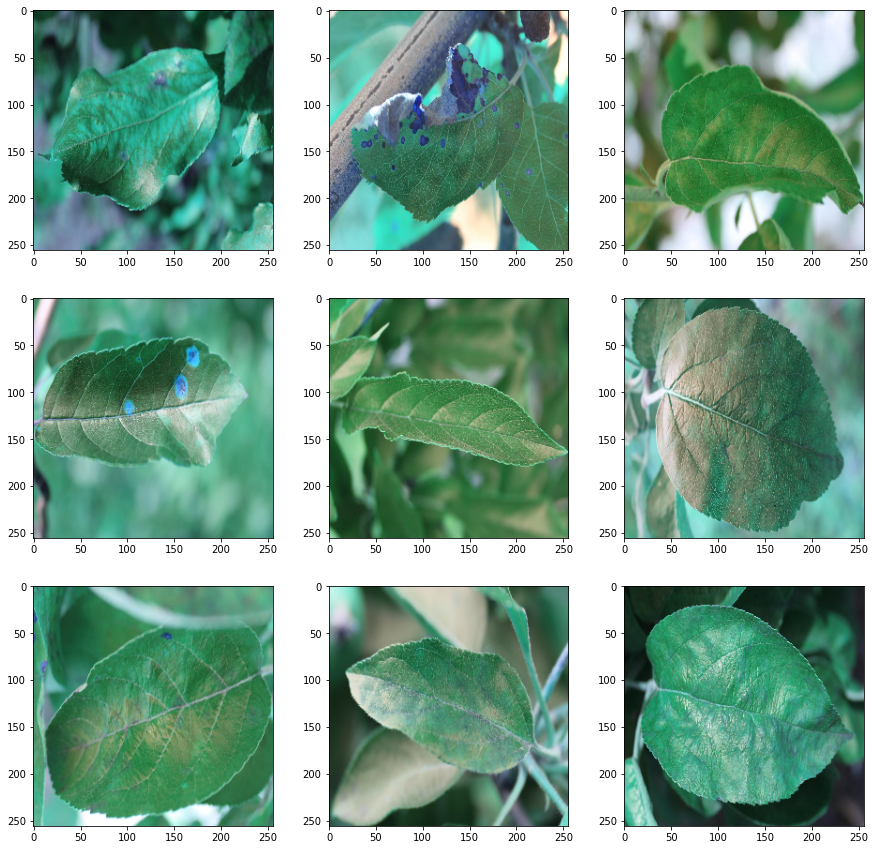

In [7]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(img[i])

In [8]:
train_labels = np.float32(train.loc[:, 'healthy':'scab'].values)

train, val = train_test_split(train, test_size = 0.15)


In [9]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    fill_mode='nearest',
    shear_range=0.1,
    rescale=1/255,
    brightness_range=[0.5, 1.5])


In [10]:
train_generator=train_datagen.flow_from_dataframe(train,directory='/kaggle/input/plant-pathology-2020-fgvc7/images/',
                                                      target_size=(384,384),
                                                      x_col="image_id",
                                                      y_col=['healthy','multiple_diseases','rust','scab'],
                                                      class_mode='raw',
                                                      shuffle=False,
                                                       subset='training',
                                                      batch_size=32)

Found 1547 validated image filenames.


In [11]:
val_generator=train_datagen.flow_from_dataframe(val,directory='/kaggle/input/plant-pathology-2020-fgvc7/images/',
                                                      target_size=(384,384),
                                                      x_col="image_id",
                                                      y_col=['healthy','multiple_diseases','rust','scab'],
                                                      class_mode='raw',
                                                      shuffle=False,
                                                      batch_size=32,
                                                  )

Found 274 validated image filenames.


In [12]:
test_generator=train_datagen.flow_from_dataframe(test,directory='/kaggle/input/plant-pathology-2020-fgvc7/images/',
                                                      target_size=(384,384),
                                                      x_col="image_id",
                                                      y_col=None,
                                                      class_mode=None,
                                                      shuffle=False,
                                                      batch_size=32)

Found 1821 validated image filenames.


In [13]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
from keras import optimizers
model_finetuned = ResNet50(include_top=False, weights='imagenet', input_shape=(384,384,3))
x = model_finetuned.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)
model_finetuned = Model(inputs=model_finetuned.input, outputs=predictions)
model_finetuned.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
model_finetuned.summary()

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning:

The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.



94658560/94653016 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 390, 390, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 192, 192, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 192, 192, 64) 256         conv1[0][0]                      
___________________________

In [14]:
from keras.callbacks import ReduceLROnPlateau

In [15]:
history_1 = model_finetuned.fit_generator(train_generator,                                    
                                  steps_per_epoch=100, 
                                  epochs=25,validation_data=val_generator,validation_steps=100
                                  ,verbose=1,callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],use_multiprocessing=False,
               shuffle=True)

Epoch 1/25
100/100 [==============================] - 494s 5s/step - loss: 0.5778 - accuracy: 0.8224 - val_loss: 8.1259 - val_accuracy: 0.2879
Epoch 2/25
100/100 [==============================] - 449s 4s/step - loss: 0.3495 - accuracy: 0.8993 - val_loss: 1.8923 - val_accuracy: 0.2886
Epoch 3/25
100/100 [==============================] - 469s 5s/step - loss: 0.2815 - accuracy: 0.9107 - val_loss: 4.3011 - val_accuracy: 0.2886
Epoch 4/25
100/100 [==============================] - 454s 5s/step - loss: 0.2390 - accuracy: 0.9291 - val_loss: 2.1020 - val_accuracy: 0.2879
Epoch 5/25
100/100 [==============================] - 453s 5s/step - loss: 0.2582 - accuracy: 0.9174 - val_loss: 3.5731 - val_accuracy: 0.3132
Epoch 6/25
100/100 [==============================] - 450s 5s/step - loss: 0.1672 - accuracy: 0.9487 - val_loss: 2.2658 - val_accuracy: 0.3250
Epoch 7/25
100/100 [==============================] - 445s 4s/step - loss: 0.1289 - accuracy: 0.9573 - val_loss: 1.7676 - val_accuracy: 0.2866

/opt/conda/lib/python3.6/site-packages/keras/utils/data_utils.py:616: UserWarning:

The input 17 could not be retrieved. It could be because a worker has died.



100/100 [==============================] - 506s 5s/step - loss: 0.0226 - accuracy: 0.9937 - val_loss: 0.3183 - val_accuracy: 0.9501
Epoch 24/25
100/100 [==============================] - 451s 5s/step - loss: 0.0191 - accuracy: 0.9943 - val_loss: 0.0303 - val_accuracy: 0.9563
Epoch 25/25
100/100 [==============================] - 468s 5s/step - loss: 0.0071 - accuracy: 0.9994 - val_loss: 0.0674 - val_accuracy: 0.9511


In [16]:
fig = go.Figure(data=[
    go.Line(name='train_acc', x=history_1.epoch, y=history_1.history['accuracy']),
    go.Line(name='Val_acc', x=history_1.epoch, y=history_1.history['val_accuracy'])])

fig.update_layout(
    title="Accuracy",
    xaxis_title="epoch",
    yaxis_title="accuracy",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ))
fig

/opt/conda/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [17]:
SUB_PATH = "../input/plant-pathology-2020-fgvc7/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
probs_RESNET = model_finetuned.predict(test_generator, verbose=1)
sub.loc[:, 'healthy':] = probs_RESNET
sub.to_csv('submission_RESNET.csv', index=False)
sub.head()

57/57 [==============================] - 127s 2s/step


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,5.960506e-09,4.585603e-05,9.999541e-01,4.434595e-09
1,Test_1,1.926975e-05,2.026743e-03,9.979448e-01,9.206301e-06
2,Test_2,1.578991e-09,8.154808e-08,4.192415e-15,9.999999e-01
3,Test_3,9.999996e-01,9.463584e-08,8.326596e-08,2.126297e-07
4,Test_4,2.521952e-12,9.498650e-08,9.999999e-01,1.179961e-12
